# Day 11, possibly dynamic programming?

- [Day 11](https://adventofcode.com/2018/day/11)

This is a challenge that, to me, sounds like we need to use dynamic programming. For a large problem set, you'd only want to keep a running total. Since we want the top-left grid coordinate, you'd start at `(max(x), max(y))` and work your way backwards, taking advantage of the calculations already done for the `x + 1, y`, `x + 2, y`, `x, y + 1`, ..., `x + 2, y + 2` positions. For a 300 x 300 grid that would mean you only need to keep the last 600 calculation results in memory and let you use `max()` on the running calculation.

However, for a 300x300 grid it is simpler to just vectorise the hell out of the grid, using `numpy`.

The formula for any given grid coordinate power value is

$$\lfloor\frac{((x + 10)y + serial) \times (x + 10)}{100}\rfloor \bmod 10 - 5$$

but I must note that subtracting 5 at the end doesn't actually matter to the outcome. Either the cell score falls in the range $[0, 10)$ or $[-5, 5)$, with the 3 x 3 grid score in the range $[0, 81]$ or $[-45, 36]$. Not that `numpy` much cares.

Summing the sliding 3x3 windows is a little more interesting here. There are 298 x 298 complete 3 x 3 sub-grids that need to be considered here (from `((1, 1) ... (3, 3))` all the way to `((298, 298) ... (300, 300))`), and we need to create sums for all those sub windows. I'm using the [`numpy.lib.stride_tricks.as_strided()` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html) here to step over the whole matrix in those 3x3 windows, so we can sum them all and produce a new `(298 x 298)` matrix of sums at coordinates that match the top-level corner of each sub-matrix.


In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

# These values never change, so can be made globals
GRIDSIZE = 300
XX, YY = np.meshgrid(np.arange(1, GRIDSIZE + 1), np.arange(1, GRIDSIZE + 1))
RACK_ID = XX + 10


def grid_powers(serial):
    # calculate power levels
    return (RACK_ID * YY + serial) * RACK_ID // 100 % 10 - 5


def summed_grid_powers(power_levels, window_size=3):
    # sum levels for 3 x 3 subgrids; substitute edges for zeros

    window_count = GRIDSIZE - window_size + 1
    # output shape, 2d grid of 2d windows
    shape = (window_count, window_count, window_size, window_size)
    # per shape axis, the stride across power_levels matches up to the
    # same axes.
    strides = power_levels.strides * 2

    # we want to sum every subwindow, so it is time to start striding
    # we need to produce a (window_count, window_count, window_size, window_size)
    # matrix that then is summed on the last 2 axes.
    return as_strided(power_levels, shape, strides).sum(axis=(2, 3))


def max_grid(serial):
    summed = summed_grid_powers(grid_powers(serial))

    # produce the (x, y) coordinates for the largest 3x3 grid top-left coordinate
    # argmax() flattens the array and gives us an index based on that, so we need
    # numpy.unravel to give back the original y, x coordinates.
    y, x = np.unravel_index(summed.argmax(), summed.shape)
    # Translate from zero to one-based indexing
    return x + 1, y + 1

In [2]:
power_tests = {
    # serial, x, y: power level
    (8, 3, 5): 4,
    (57, 122, 79): -5,
    (39, 217, 196): 0,
    (71, 101, 153): 4,
}

for (tserial, x, y), expected in power_tests.items():
    # indexing a [y, x] arranged matrix with 0-based offsets
    assert grid_powers(tserial)[y - 1, x - 1] == expected

max_tests = {
    18: (33, 45),
    42: (21, 61),
}

for tserial, expected in max_tests.items():
    assert max_grid(tserial) == expected

In [3]:
import aocd

data = aocd.get_data(day=11, year=2018)
serial = int(data)

In [4]:
x, y = max_grid(serial)
print(f"Part 1: {x},{y}")

Part 1: 44,37


In [5]:
%timeit grid_powers(serial)
%timeit max_grid(serial)

367 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Part 2, variable window size

Now I'm really glad I worked out how to do striding here. We can now produce separate summed matrices for each size. Vectorised sums over striding views does slow down dramatically in the middle somewhere, see timings below.

We still may want to explore dynamic programming here, however, as that would let us calculate values for all possible sizes as you traverse from 300, 300 down to 1,1 in one sweep. That's for later however.


In [6]:
%timeit grid_powers(serial)
power_levels = grid_powers(serial)
%timeit summed_grid_powers(power_levels)
%timeit summed_grid_powers(power_levels, 150)  # performance degrades
%timeit summed_grid_powers(power_levels, 300)  # performance degrades

357 µs ± 4.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.64 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
57.3 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.6 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
def optimal_window_size(serial):
    power_levels = grid_powers(serial)
    # big matrix with 300 flattened power level arrays,
    # all padded back to 300 x 300 size so we can determine which one
    # has the most power output, then extract the size and grid position
    by_size = np.stack(
        [
            np.pad(summed_grid_powers(power_levels, i + 1), (0, i), "constant")
            for i in range(GRIDSIZE)
        ]
    ).reshape(GRIDSIZE, -1)
    size = by_size.max(axis=1).argmax()
    y, x = np.unravel_index(by_size[size].argmax(), power_levels.shape)
    return x + 1, y + 1, size + 1

In [8]:
optimal_tests = {
    18: (90, 269, 16),
    42: (232, 251, 12),
}
for tserial, expected in optimal_tests.items():
    assert optimal_window_size(tserial) == expected

In [9]:
x, y, s = optimal_window_size(serial)
print(f"Part 2: {x},{y},{s}")

Part 2: 235,87,13


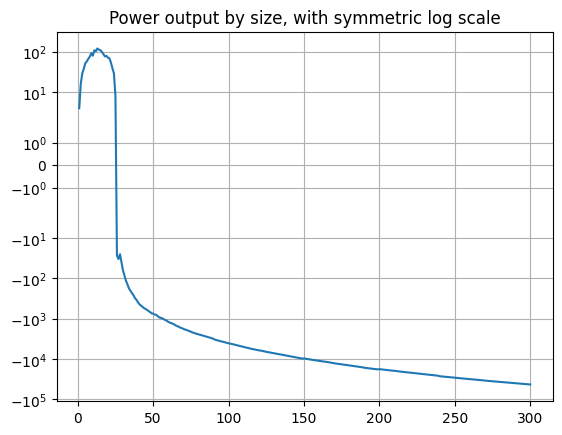

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.yscale("symlog")
plt.grid(True)
plt.title("Power output by size, with symmetric log scale")
power_levels = grid_powers(serial)
maxima = [summed_grid_powers(power_levels, i + 1).max() for i in range(300)]
_ = plt.plot(np.arange(1, len(maxima) + 1), maxima)

## Avoiding the performance issues

We are now constantly summing and re-summing values for the larger and larger window sizes. But for any given `size`, we can reuse `size - 1` if we can add the missing column and row values. We can keep a running total
of those on hand, with a running sum of `x` and `y`, where `y` is offset by one to avoid summing the bottom-right-hand corner twice.

We are essentially adding columns and rows into the original cell in the top left corner, expanding out to the next row and column each step. The cells here are relative to a given top-left corner cell:

| ⋱   | 0                                        | 1                                        | 2                                         | 3                                        |
| --- | ---------------------------------------- | ---------------------------------------- | ----------------------------------------- | ---------------------------------------- |
| 0   | A                                        | <span style="color: firebrick">B</span>  | <span style="color: forestgreen">C</span> | <span style="color: steelblue">D</span>  |
| 1   | <span style="color: red">E</span>        | <span style="color: red">F</span>        | <span style="color: forestgreen">G</span> | <span style="color: steelblue">H</span>  |
| 2   | <span style="color: limegreen">I</span>  | <span style="color: limegreen">J</span>  | <span style="color: limegreen">K</span>   | <span style="color: steelblue">L</span>  |
| 3   | <span style="color: dodgerblue">M</span> | <span style="color: dodgerblue">N</span> | <span style="color: dodgerblue">O</span>  | <span style="color: dodgerblue">P</span> |

1. For window-size 1, only `A` is needed
2. For window-size 2 we add in the row cells `E` and `F` and column cell `B`
3. For window-size 3, add in row cells `I`, `J` and `K`, and column cells `C` and `G`
4. For window-size 3, add in row cells `M`, `N`, `O` and `P`, and column cells `D`, `H` and `L`

Note that these are all for just one cell. But for the cell _below_ this one in the table, there are corresponding surrounding cells to add, and what is cell `E` for the one in the top row, is cell `A` in that very row, with `F` being the same as `B` in the row above. The same applies to the top cell in the column to the right; there `A` is the equivalent of `B` for the cell in the top left corner, etc.

We can take advantage of that by keeping a running sum for rows and columns where we roll the running sums up (for rows) and left (for columns) before adding their numbers to our summed matrix. We use the original 1x1 window power matrix to supply the values. This matrix is rolled up and left a step each time, so first `F`, then `K` then `P` is in the top-left corner. We then roll the column sums up and add the rolled power values to the column sums and add these to the windowed sums. Then we roll the column sums to the left, add them to the windowed sums, and only then add the rolled power values to the column sums.


In [11]:
def optimal_window_size(serial):
    power = grid_powers(serial)
    summed = np.copy(power)
    best_size = 1
    highest_power = summed.max()
    best_pos = summed.argmax()
    # updated sums for rows and columns to update the current size with
    power_rolled = rowsums = colsums = power

    for size in range(2, GRIDSIZE + 1):
        # matrix to update our running row and column sums;
        # roll up and left, and clear the last row and column
        power_rolled = np.roll(power_rolled, (-1, -1), (0, 1))
        power_rolled[-1, :] = 0
        power_rolled[:, -1] = 0
        # roll rowsums up, clear last row and add power_rolled values
        # Then add these to our summed windows
        rowsums = np.roll(rowsums, -1, 0)
        rowsums[-1, :] = 0
        rowsums += power_rolled
        summed += rowsums
        # roll the column sums to the left, add these to the summed
        # windows first, then add power_rolled to the column sums.
        colsums = np.roll(colsums, -1, 1)
        colsums[:, -1] = 0
        summed += colsums
        colsums += power_rolled
        # finally, clear the next inner row and column of summed
        summed[-(size - 1) :, :] = 0
        summed[:, -(size - 1) :] = 0

        # now our summed matrix is up to date for this window size. Check if it
        # has a larger power output
        power_output = summed.max()
        if power_output > highest_power:
            highest_power = power_output
            best_size = size
            best_pos = summed.argmax()

    y, x = np.unravel_index(best_pos, summed.shape)
    return x + 1, y + 1, best_size

In [12]:
optimal_window_size(serial)

(235, 87, 13)

In [13]:
%timeit optimal_window_size(serial)

100 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
